# Train-Test splits

- In this notebook the approach is changed. Instead of implementing equidistant splits of 1 month or day, the splits are now determined by the percentage length of the training set. Ultimately, a timestamp $t$ is calculated, designating data before $t$ as the training set and data at and after $t$ as the testing set.
- Three splits are computed in total:
    - 50%-50% Training-Test: This setting outlines the minimum amount of training data. The number of appearing families in testing set is the maximum compared to the other following splits.
        1. Once the 50%-50% split $t$ is found, the number of appearing families in testing set is computed;
        2. Subsequently, the splits after $t$ are iterated as long as the the number of appearing families remains the same;
        3. The last iterated split is the best one as it ensures a longer training dataset while maintaining the same number of appearing families. The training set is ultimately composed of 51.1% of data points.
    - 70%-30% Training-Test: In this split, a significant percentage of the training set is favored, with less concern about the number of new appearing families in the testing set.
    - 62.33%-37.67% Training-Test: An objective function is constructed to maximize both the train-test balancing (linearly favoring splits as the percentage approaches 70%) and the number of appearing families in the testing set. The identified split represents a trade-off between these two scores.

In [1]:
from src.data_splits.utils.best_split_utils import *

In [2]:
# Get the merged malware data
df = pd.read_csv("../vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [3]:
fsd = "first_submission_date"
# Convert the timestamps to datetime format
df_dt = df.copy()
df_dt[fsd] = df_dt[fsd].apply(lambda t: pd.to_datetime(t, unit='s'))

## Choose the Train-Test split by choosing Training set length

Given the length in % of the training set, the dataset is split by the time axis using the bisection method.

In [4]:
def find_balanced_split(timestamps, training_perc):
    low, high = 0, len(timestamps) - 1
    idx = - 1
    while low <= high:
        mid = (low + high) // 2
        mid_value = timestamps[mid]
        perc_train = len(df_dt[df_dt[fsd] < mid_value]) / len(df_dt)
        if perc_train == training_perc:
            idx = mid
            high = mid - 1
        elif perc_train < training_perc:
            # Search in the right half
            low = mid + 1
        else:
            # Search in the left half
            high = mid - 1

    return timestamps[idx]

In [5]:
def compute_bs_af(df: pd.DataFrame, ref_df: pd.DataFrame, date_split: pd.Timestamp,
                    bs_f: Callable = lambda x: 1 - np.abs(x - 0.7) / 0.7):
    # Train-Test balancing: this score increases as the training test length
    # in % is approaching 70% of the samples
    train_prop = len(df[df[fsd] < date_split]) / len(ref_df)
    bs = bs_f(train_prop)

    # % Appearing families in testing set
    df_train_nonzero = split_and_group_nonzero(src_df=df, split_condition=df[fsd] < date_split)
    df_test_nonzero = split_and_group_nonzero(src_df=df, split_condition=df[fsd] >= date_split)

    test_families = df_test_nonzero["family"].unique()
    af = ((len(test_families) - len(np.intersect1d(df_train_nonzero["family"].unique(), test_families))) /
          len(ref_df["family"].unique()))

    return {"bs": bs, "af": af}

In [6]:
def max_train_from_new_f(splits):
    ref_df_dt = df_dt.copy()
    af_f = lambda s: compute_bs_af(df_dt, ref_df_dt, s)["af"]
    ref_af = af_f(splits[0])
    for i in range(1, len(splits)):
        if af_f(splits[i]) < ref_af:
            return splits[i - 1]
    return splits[len(splits) - 1]
        

In [7]:
t_unique = df_dt[fsd].sort_values().unique()
t_best_split = find_balanced_split(t_unique, 0.7)
print_statistics(df_dt, t_best_split, f"Split at {t_best_split}")

------------------------------------------------------------------
Report: Split at 2021-12-09 08:48:58
	Training set length: 46900, (70.0%)
	Testing set length: 20100, (30.0%)
	Num families in training: 663
	Num families in testing: 606
	Common families: 599
	Families in training but not in testing: 64 (9.55%)
	Families in testing but not in training: 7 (1.04%)


In [8]:
t_unique = df_dt[fsd].sort_values().unique()
t_split = find_balanced_split(t_unique, 0.5)
date_splits = [t for t in t_unique if t >= t_split]
# After computing the 50-50% split, maximize the training set length as the
# number of appearing families in testing set remains the same.
t_min_split = max_train_from_new_f(date_splits)
print_statistics(df_dt, t_min_split, f"Split at {t_min_split}")

------------------------------------------------------------------
Report: Split at 2021-08-26 12:40:17
	Training set length: 34240, (51.1%)
	Testing set length: 32760, (48.9%)
	Num families in training: 650
	Num families in testing: 650
	Common families: 630
	Families in training but not in testing: 20 (2.99%)
	Families in testing but not in training: 20 (2.99%)


In [9]:
date_splits = [t for t in t_unique if t_min_split <= t <= t_best_split]

In [10]:
df_scores, df_ref_scores = df_dt.copy(), df_dt.copy()
js_scores, perc_app_families, balance_scores = [], [], []
for date_split in date_splits:
    scores = compute_bs_af(df=df_scores, ref_df=df_ref_scores, date_split=date_split)
    perc_app_families.append(scores["af"])
    balance_scores.append(scores["bs"])

In [11]:
# Min-Max normalization
perc_app_families_min_max = ((perc_app_families - np.min(perc_app_families)) /
                             (np.max(perc_app_families) - np.min(perc_app_families)))

balance_scores_min_max = ((balance_scores - np.min(balance_scores)) /
                          (np.max(balance_scores) - np.min(balance_scores)))

In [12]:
f_objective = perc_app_families_min_max + balance_scores_min_max
t_split_mid = date_splits[np.argmax(f_objective)]
print_statistics(df_dt, t_split_mid)

------------------------------------------------------------------
Report: 
	Training set length: 41763, (62.33%)
	Testing set length: 25237, (37.67%)
	Num families in training: 654
	Num families in testing: 632
	Common families: 616
	Families in training but not in testing: 38 (5.67%)
	Families in testing but not in training: 16 (2.39%)


In [13]:
final_splits = [t_min_split, t_split_mid, t_best_split]

FileNotFoundError: [Errno 2] No such file or directory: '../../doc/best_splits_img/split-2021-08-26 12:40:17.png'

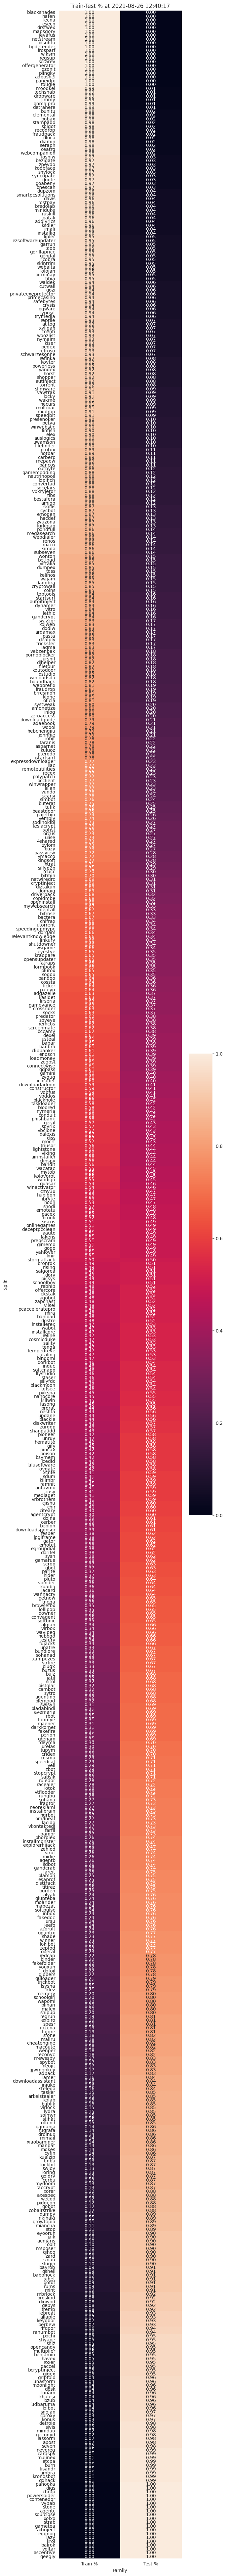

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for split in final_splits:

    df_split = split_and_group(df_dt, df_dt[fsd] < split, df_dt.copy())
    df_split["train_perc"] = df_split["count"] / 100
    df_split["test_perc"] = 1 - df_split["train_perc"]
    
    df_split = df_split.sort_values(by="train_perc", ascending=False)    
    split_m = df_split[["train_perc", "test_perc"]].to_numpy()

    # Create a heatmap using seaborn
    plt.figure(figsize=(6, 100))
    sns.heatmap(split_m, annot=True, fmt=".2f",
                          xticklabels=["Train %", "Test %"], 
                          yticklabels=df_split["family"])

    plt.xlabel("Family")
    plt.ylabel("Split")
    plt.title(f"Train-Test % at {split}")
    plt.savefig(f"../../doc/best_splits_img/split-{split}.png")

    # Show the plot
    plt.show()